Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My Drive/optml_gan2
PATH = './repo/' 

Mounted at /content/drive
/content/drive/My Drive/optml_gan2


In [2]:
%matplotlib inline
from __future__ import print_function

import argparse
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 123

#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


# Source code

## Data handling

In [3]:
# there are problems with downloading CelebA
# see https://stackoverflow.com/questions/65528568/how-do-i-load-the-celeba-dataset-on-google-colab-using-torch-vision-without-ru

def get_dataset(name, image_size):
    # torchvision dataset
    dataset = None

    # number of channels in the training images (3 for color, 1 for grayscale)
    nc = None

    if name == 'cifar10':
        nc = 3

        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # todo: Why do we use these means and stds ? 
        )])

        dataset = torchvision.datasets.CIFAR10(dataroot, download=True, 
                                            train=True,  transform=transform)
    elif name == 'mnist':
        nc = 1

        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)) # todo: Why do we use these means and stds and not the mean and std of the dataset?
        ])

        dataset = torchvision.datasets.MNIST(dataroot, download=True, 
                                            train=True,  transform=transform)
    else:
        raise ValueError("Unknown dataset name")
    
    return dataset, nc

In [4]:
def plot_img(dataloader, dataset_name):
    # Plot some training images
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.savefig(PATH + 'img/training_images_' + dataset_name, format="png",dpi=400)
    return

## Utils

In [5]:
def count_parameters(model):
    # from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Model

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
def init_net(model, device):
    # Create the generator
    net = model.to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        net = nn.DataParallel(net, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    #net.apply(weights_init)

    # Print the model
    print(net)
    return net

## Losses

In [169]:
# stability constant
EPS = 1e-15


# KL-divergence
def loss_gen_kl(dis_output, eps=EPS):
    return - torch.log(dis_output + eps).mean() 

def loss_dis_kl(dis_output_real, dis_output_fake, eps=EPS):
    return - (torch.log(dis_output_real + eps)).mean() - (torch.log(1. - dis_output_fake + eps)).mean()


# Wasserstein distance
# Requires special output of the network + weight clipping / grad penalty
def loss_gen_wasser(dis_output, eps=EPS):
    return - dis_output.mean()

def loss_dis_wasser(dis_output_real, dis_output_fake, eps=EPS):
    return - (dis_output_real.mean() - dis_output_fake.mean())


# Hinge loss
def loss_gen_hinge(dis_output, eps=EPS):
    return - dis_output.mean()

def loss_dis_hinge(dis_output_real, dis_output_fake, eps=EPS):
    return torch.nn.ReLU()(1.0 - dis_output_real).mean() + torch.nn.ReLU()(1.0 + dis_output_fake).mean()


loss_dict = {
    "kl"    : (loss_dis_kl, loss_gen_kl),
    "wass"  : (loss_dis_wasser, loss_gen_wasser),
    "hinge" : (loss_dis_hinge, loss_gen_hinge)
}

## Training

In [170]:
def init_optimizers(netD, netG, lrD, lrG, beta1, nz, device):
    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # todo: outdated now
    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

    return fixed_noise, real_label, fake_label, optimizerD, optimizerG

def init_losses(loss_type):
    if loss_type not in loss_dict.keys():
        raise Exception("Unknown loss type")

    return loss_dict[loss_type]

In [171]:
from torch.autograd import Variable

def gradient_penalty(device, discriminator, data_gen, data_real, lambda_reg=0.1):
    alpha = torch.rand(data_real.shape[0], 1).to(device)
    dims_to_add = len(data_real.size()) - 2
    for i in range(dims_to_add):
        alpha = alpha.unsqueeze(-1)

    interpolates = (alpha * data_real + ((1. - alpha) * data_gen)).to(device)

    interpolates = Variable(interpolates, requires_grad=True)

    disc_interpolates = discriminator(interpolates)
    grad_outputs = torch.ones(disc_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates, grad_outputs=grad_outputs,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    gp_val = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg

    return gp_val

In [172]:
def discriminator_step(f_loss_dis, netD, netG, data, device, real_label, fake_label, gp_coef):
    netD.zero_grad()

    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output_real = netD(real_cpu).view(-1)

    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_label)
    output_fake = netD(fake.detach()).view(-1)

    errD = f_loss_dis(output_real, output_fake)

    if gp_coef != 0.0:
        errD += gp_coef * gradient_penalty(device, netD, fake, real_cpu)

    errD.backward()
    optimizerD.step()

    D_x = output_real.mean().item()
    D_G_z1 = output_fake.mean().item()

    return D_x, D_G_z1, errD, label, fake


def generator_step(f_loss_gen, netD, netG, label, fake, real_label):
    netG.zero_grad()
    output = netD(fake).view(-1)
    
    errG = f_loss_gen(output)
    errG.backward()
    
    D_G_z2 = output.mean().item()

    optimizerG.step()
    return D_G_z2, errG

In [ ]:
class Training:
    def __init__(self, loss_name, netD, netG, device, real_label, fake_label, dataloader, num_epochs,
                 fixed_noise, iter_per_epoch_dis=1, iter_per_epoch_gen=1, grad_penalty_coef=0.0):
        self.loss_name = loss_name
        self.netD, self.netG = netD, netG
        self.device = device
        self.real_label, self.fake_label = real_label, fake_label
        self.dataloader = dataloader
        self.num_epochs = num_epochs
        self.fixed_noise = fixed_noise
        self.iter_per_epoch_dis, self.iter_per_epoch_gen = iter_per_epoch_dis, iter_per_epoch_gen
        self.grad_penalty_coef = grad_penalty_coef
    
    def _output_training_stats(epoch, i, size, errD, errG, D_x, D_G_z1, D_G_z2, t0):
        if i == size:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f t: %2.3f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD, errG, D_x, D_G_z1, D_G_z2, time.time()-t0))
        elif i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD, errG, D_x, D_G_z1, D_G_z2))
    
    def _save_gen_output(self, iters, epoch, i, img_list):
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    def train(self):
        f_loss_dis, f_loss_gen = init_losses(self.loss_name)

        G_losses, D_losses = [], []
        img_list = []
        iters = 0

        print("Starting Training Loop...")

        D_x, D_G_z1, errD, label, fake = None, None, None, None, None
        D_G_z2, errG = None, None

        for epoch in range(self.num_epochs):
            t0 = time.time()

            for i, data in enumerate(self.dataloader, 0):
                for _ in range(self.iter_per_epoch_dis):
                    D_x, D_G_z1, errD, label, fake = discriminator_step(
                        f_loss_dis, self.netD, self.netG, data, self.device, 
                        self.real_label, self.fake_label, self.grad_penalty_coef
                    )

                for _ in range(self.iter_per_epoch_gen):
                    D_G_z2, errG = generator_step(
                        f_loss_gen, self.netD, self.netG, label, fake, self.real_label
                    )
                
                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                size = len(dataloader) - 1
                self._output_training_stats(epoch, i, size, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, t0)
                
                # Check how the generator is doing by saving G's output on fixed_noise
                self._save_gen_output(iters, epoch, i, img_list)
                    
                iters += 1

        stats = {
            'img_list' : img_list,
            'G_losses' : G_losses,
            'D_losses' : D_losses  
        }

        return stats

## Visualization

In [174]:
def plot_loss(G_losses, D_losses, save = False):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

    if save == True:
      plt.savefig(PATH + 'img/loss', format="png",dpi=400)

    plt.show()
    return

In [175]:
def plot_realvsfake(dataloader, device, img_list, save = False):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    if save == True:
        plt.savefig(PATH + 'img/real_vs_fake', format="png",dpi=400)
    plt.show()
    return

## Serialization

In [176]:
def save_models(netG ,netD, save_path_G, save_path_D):
    torch.save(netG.state_dict(), save_path_G)
    torch.save(netD.state_dict(), save_path_D)
    print('GAN saved')
    return

In [177]:
def load_models(ngpu, Discriminator, Generator, save_path_G, save_path_D):

    netD = Discriminator(ngpu).to(device)
    netD.load_state_dict(torch.load(save_path_D))
    netD.eval()

    netG = Generator(ngpu).to(device)
    netG.load_state_dict(torch.load(save_path_G))
    netG.eval()
    
    print('GAN loaded')
    return netD, netG

# Training

## Architectures

https://keras.io/examples/generative/conditional_gan/

In [178]:
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(nz, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, nc * 28 * 28)
        return    

    # forward method
    def forward(self, x): 
        x = x.reshape([x.shape[0], -1])

        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        x = x.reshape((-1, nc, 28, 28))
        return x
    

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc, loss):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)

        self.fc4 = nn.Linear(self.fc3.out_features, 1)

        if loss == "kl":
            # for KL - discriminator is a classifier
            self.act = torch.sigmoid
        else:
            # for Wasserstein and hinge - discriminator is a critic
            self.act = lambda x: x

        return    

    def forward(self, x):
        x = x.reshape([x.shape[0], -1])
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = self.act(self.fc4(x))
        return x

## Parameters

In [179]:
# Root directory for dataset
dataroot = PATH + "data/"

# Dataset name
dataset_name = 'mnist' # 'cifar10' or 'mnist'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28 # 28 for mnist, 64 for others

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [185]:
# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lrD = 2e-4
lrG = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.9 # 0.9 == default

In [186]:
dataset, nc = get_dataset(dataset_name, image_size)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#print(dataset)
#plot_img(dataloader, dataset_name)

In [187]:
loss_name = "wass" # wass, hinge
iter_dis, iter_gen, gp_val = 1, 1, 0.0

if loss_name == "wass":
    iter_dis, gp_val = 5, 10.0


netG = init_net(Generator(ngpu, nc, nz), device)
print('Generator parameters', count_parameters(netG))

netD = init_net(Discriminator(ngpu, nc, loss_name), device)
print('Discriminator parameters', count_parameters(netD))

Generator(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Generator parameters 1493520
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)
Discriminator parameters 1460225


## Run

In [188]:
fixed_noise, real_label, fake_label, optimizerD, optimizerG = init_optimizers(netD, netG, lrD, lrG, beta1, nz, device)

In [189]:
gan_training = Training(loss_name, netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise, iter_dis, iter_gen, gp_val)

stats = gan_training.train()

Starting Training Loop...
[0/10][0/469]	Loss_D: -0.5640	Loss_G: 0.0001	D(x): 1.5579	D(G(z)): 0.0007 / -0.0001
[0/10][50/469]	Loss_D: -3346.9844	Loss_G: -5662.6436	D(x): 10077.6729	D(G(z)): 5701.4238 / 5662.6436
[0/10][100/469]	Loss_D: -24567.3711	Loss_G: 68950.9531	D(x): -18284.1953	D(G(z)): -68503.8906 / -68950.9531
[0/10][150/469]	Loss_D: -4934.7070	Loss_G: 8852.2168	D(x): 1954.6010	D(G(z)): -9966.3438 / -8852.2168
[0/10][200/469]	Loss_D: -12245.5723	Loss_G: 12924.0293	D(x): 4223.1787	D(G(z)): -13017.5693 / -12924.0293
[0/10][250/469]	Loss_D: 1664.5344	Loss_G: -7371.1016	D(x): 7203.9795	D(G(z)): 8177.3047 / 7371.1016
[0/10][300/469]	Loss_D: -2468.8401	Loss_G: 9396.6699	D(x): -6551.4404	D(G(z)): -9243.1582 / -9396.6699
[0/10][350/469]	Loss_D: 406.4109	Loss_G: -7400.8721	D(x): 7704.3203	D(G(z)): 7491.7632 / 7400.8721
[0/10][400/469]	Loss_D: -3262.3062	Loss_G: -2574.6082	D(x): 9319.8066	D(G(z)): 2777.2649 / 2574.6082
[0/10][450/469]	Loss_D: -523.9283	Loss_G: 588.2764	D(x): 500.8245	D(G(

In [190]:
img_list = stats['img_list']
G_losses = stats['G_losses']
D_losses = stats['D_losses']

# Visualization

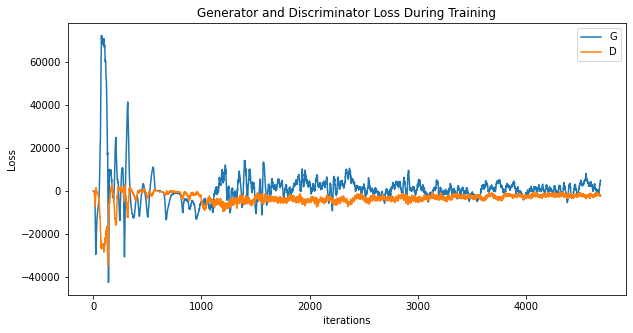

In [191]:
plot_loss(G_losses, D_losses, save = False)

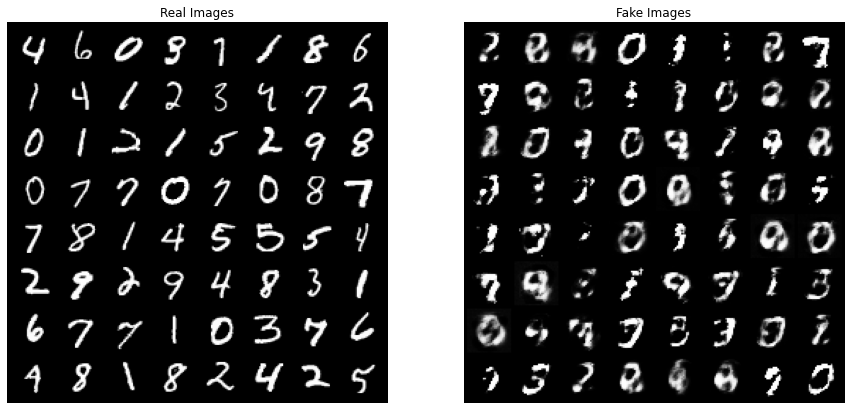

In [192]:
plot_realvsfake(dataloader, device, img_list, save = False)

## G’s progression



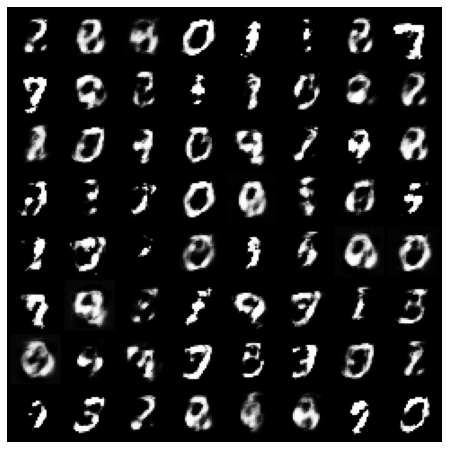

In [193]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Serialization

In [46]:
# Paths to load and save the models
# todo: put the model description in the name of the file
from datetime import datetime

prefix = "models/" + str(datetime.date(datetime.now())).replace('-', '_') + "_"

model_name_G = prefix +'model_G'
save_path_G = PATH + model_name_G

model_name_D = prefix +'model_D'
save_path_D = PATH + model_name_D

In [ ]:
save_models(netG ,netD, save_path_G, save_path_D)

In [ ]:
netD, netG = load_models(ngpu, Discriminator, Generator, save_path_G, save_path_D)

In [ ]:
# todo: save the figures --> see every plot, figure is saved just before plt.show()

# Hyper-parameter optimization (gridsearch)

In [ ]:
def run_experiment(ngpu, device, real_label, fake_label, dataset, workers,
                   batch_size, shuffle, num_epochs, fixed_noise, plot = True):
    netG = init_netG(ngpu, device)
    netD = init_netD(ngpu, device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

    # stats = train(netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise)
    
    # gan_training = Training(loss_name, netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise, iter_dis, iter_gen, gp_val)
    # stats = gan_training.train()

    if plot:
        plot_loss(G_losses, D_losses, save = False)
        plot_realvsfake(dataloader, device, img_list, save = False)
        
    return stats, dataloader, netG, netD

In [ ]:
def grid_search(ngpu, device, real_label, fake_label, dataset, workers,
                   batch_size_list, shuffle_list, num_epochs_list, fixed_noise_list, plot = True ):
    all_stats = [] 



    for batch_size in batch_size_list :
      for shuffle in shuffle_list :
        for num_epochs in num_epochs_list :
          for fixed_noise in fixed_noise_list :
              print('batch_size', batch_size, 'shuffle', shuffle, 'num_epochs', num_epochs)
              stats, dataloader, netG, netD = run_experiment(ngpu, device, real_label, fake_label, dataset, workers,
                            batch_size, shuffle, num_epochs, fixed_noise)
    
    all_stats.append(stats)

    return all_stats

In [ ]:
all_stats = grid_search(ngpu, device, real_label, fake_label, dataset, workers,
                        batch_size_list = [128, 64, 32, 16],
                        shuffle_list = [False, True],
                        num_epochs_list = [5, 10 , 20], # actually we don't need to iterate over this but I'm still putting here
                        fixed_noise_list = [ fixed_noise ], plot = True )